#Yeast Dosage-Response Curve

This is data from a real experiment, measuring the dose response of an engineered yeast line to isopentyladenine, or IP.  The yeast is engineered with a basic GFP reporter, and GFP fluorescence is measured after 12 hours, at which time we expect the cells to be at steady-state.

(Reference: [Chen et al, Nature Biotech 2005](http://www.nature.com/nbt/journal/v23/n12/abs/nbt1162.html))

---

Set up the Jupyter `matplotlib` integration, and import the `cytoflow` module.

In [1]:
%matplotlib notebook
import cytoflow as flow

Set up the experiment.  This is primarily the mapping between the flow data (wells on a microtitre plate, here) and the metadata (experimental conditions, in this case the IP concentration.)

I did a serial dilution with three dilutions per log.  Note that I specify that this metadata is of type `log`, which is represented internally as a `numpy` float, but is plotted on a log scale when we go to visualize it.

Also note that, in order to keep the size of the source distribution down, I've only included 1000 events from each tube.  The actual data set has 30,000 events from each, which gives a much prettier dose-response curve!

In [2]:
inputs = {
    "Yeast_B1_B01.fcs" : 5.0,
    "Yeast_B2_B02.fcs" : 3.75,
    "Yeast_B3_B03.fcs" : 2.8125,
    "Yeast_B4_B04.fcs" : 2.109,
    "Yeast_B5_B05.fcs" : 1.5820,
    "Yeast_B6_B06.fcs" : 1.1865,
    "Yeast_B7_B07.fcs" : 0.8899,
    "Yeast_B8_B08.fcs" : 0.6674,
    "Yeast_B9_B09.fcs" : 0.5,
    "Yeast_B10_B10.fcs" : 0.3754,
    "Yeast_B11_B11.fcs" : 0.2816,
    "Yeast_B12_B12.fcs" : 0.2112,
    "Yeast_C1_C01.fcs" : 0.1584,
    "Yeast_C2_C02.fcs" : 0.1188,
    "Yeast_C3_C03.fcs" : 0.0892,
    "Yeast_C4_C04.fcs" : 0.0668,
    "Yeast_C5_C05.fcs" : 0.05,
    "Yeast_C6_C06.fcs" : 0.0376,
    "Yeast_C7_C07.fcs" : 0.0282,
    "Yeast_C8_C08.fcs" : 0.0211,
    "Yeast_C9_C09.fcs" : 0.0159
}

tubes = []
for filename, ip in inputs.iteritems():
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip}))
    
ex = flow.ImportOp(conditions = {'IP' : "log"},
                   tubes = tubes).apply()

Let's transform the data so it's easier to visualize and work with.  We'll use a truncated log10-based transform.  The only channels we're interested in are the forward- and side-scatter channels, and the GFP output channel FITC-A.

In [3]:
ex2 = flow.LogTransformOp(channels = ["FSC-A", "SSC-A", "FITC-A"]).apply(ex)

The first step in most cytometry workflows is to filter out debris and aggregates based on morphological parameters (the forward- and side-scatter measurements.)  Because this is yeast growing in log phase on a drum roller, the distributions in FSC-A and SSC-A are pretty tight.  Let's go ahead and draw a tight polygon around the major distribution to exclude the tail.

Remember, because we're not specifying otherwise, this is a plot of *all of the data* in the experiment, not a single tube!

<IPython.core.display.Javascript object>


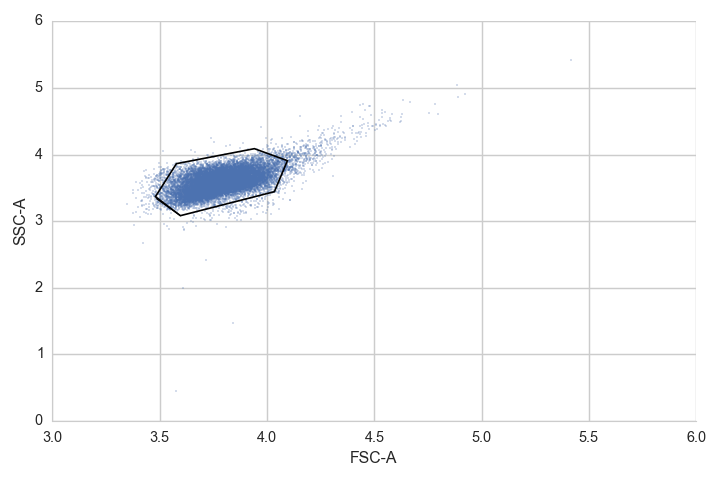

In [4]:
p = flow.PolygonOp(name = "Debris_Filter",
                   xchannel = "FSC-A",
                   ychannel = "SSC-A")
pv = p.default_view()
pv.interactive = True
pv.plot(ex2)

Apply the `PolygonOp` gate.  Remember!  This does not actually change the number of events in the experiment; it just adds another column to the data table called "Debris_Filter", which is `True` if the event falls in the gate and `False` otherwise.

In [5]:
ex3 = p.apply(ex2)

Now, let's look at the FITC-A channel, which is the one we're interested in.  First of all, just check histograms of the FITC-A distribution in each tube.  Make sure to set the `subset` trait to only include the events that aren't debris!

Sure enough, looking at the plots, it's clear that the histogram peak moves to the right as the IP concentration increases.

<IPython.core.display.Javascript object>


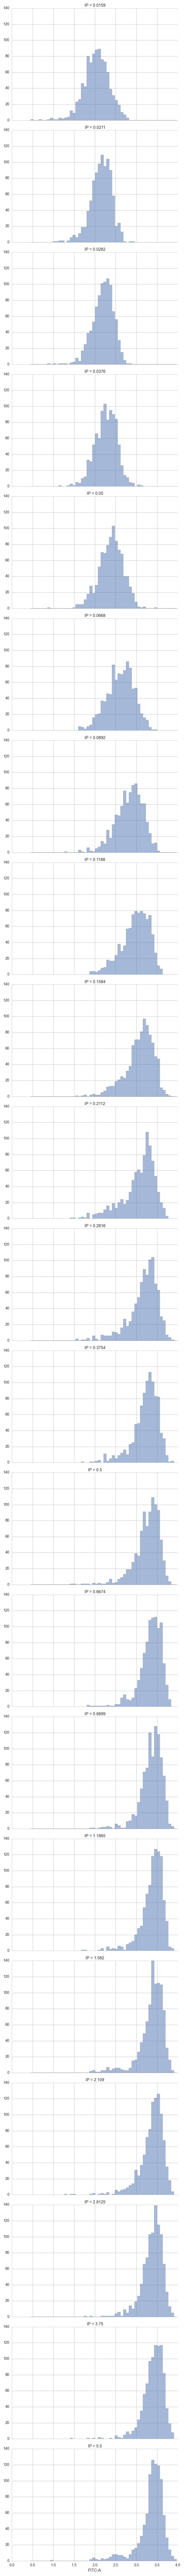

In [6]:
flow.HistogramView(channel = "FITC-A",
                   yfacet = "IP",
                   subset = "Debris_Filter == True").plot(ex3)

Now, let's get what we came for: a dose-response curve.  The `Stats1DView` view subsets the experiment by the metadata field specified in `variable` (in this case the "IP" variable) and then applies `yfunction` to each subset.  `yfunction` must be a function that takes a single list-like argument and returns a single float; it is applied to the `ychannel` channel of each subset.

Again, remember to specify the subset we're interested in.

<IPython.core.display.Javascript object>


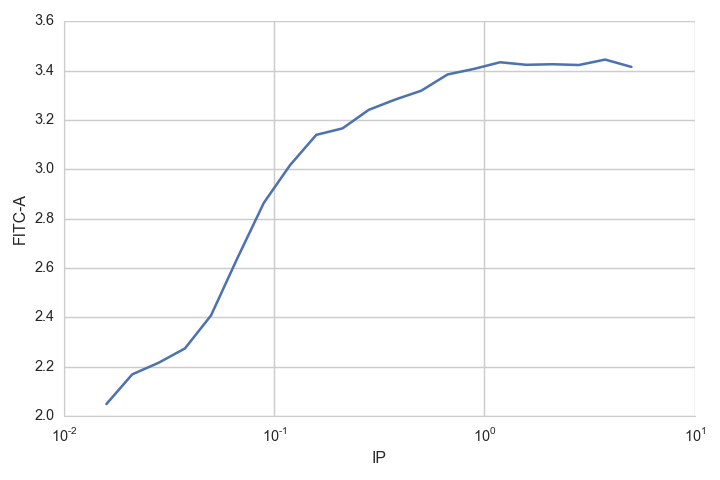

In [7]:
import numpy as np
flow.Stats1DView(by = "IP",
                 ychannel = "FITC-A",
                 yfunction = np.median,
                 subset = "Debris_Filter == True").plot(ex3)

Hrm.  That looks okay -- but the curve might look cleaner on an untransformed axis (ie, on untransformed data.)

This is pretty easy: because `Stats1DView.yfunction` takes a `Callable`, we can make an easy lambda function to un-transform the data.

<IPython.core.display.Javascript object>


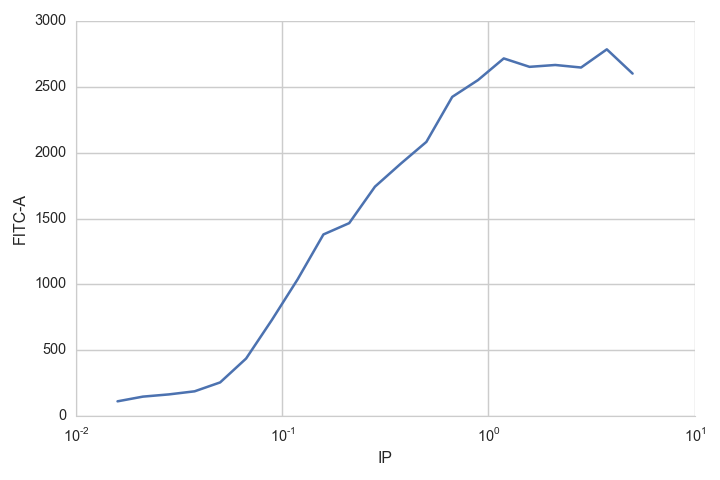

In [8]:
el = lambda x: np.median(np.power(10, x))
flow.Stats1DView(by = "IP",
                 ychannel = "FITC-A",
                 yfunction = el,
                 subset = "Debris_Filter == True").plot(ex3)

And of course, because the underlying data is just a `pandas.DataFrame`, we can manipulate it with the rest of the Scientific Python ecosystem.  Here, we get the actual median values in a table that we can manipulate further, using `pandas.DataFrame.groupby`.

In [9]:
ex3.data.query("Debris_Filter == True").groupby('IP').agg([np.median, el])["FITC-A"]

,median,<lambda>
IP,,
0.0159,2.048675,111.860001
0.0211,2.169028,147.580002
0.0282,2.216166,164.500000
0.0376,2.274158,188.000000
0.0500,2.407697,255.679993
0.0668,2.640581,437.100006
0.0892,2.864386,731.790009
0.1188,3.016883,1039.640015
0.1584,3.140002,1380.390015
